[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ninarina12/AI-PICS/blob/main/AI-PICS.ipynb)

# AI-PICS: AI Particle Image Classifier of Size

## Background
This tutorial describes an introductory-level AI/ML application to assist an experimental workflow inspired by the work of [Starodub *et al*](https://www.nature.com/articles/ncomms2288). In this work, the authors used ultra-short, intense X-ray pulses from an X-ray free-electron laser (FEL) to obtain single-shot diffraction patterns of polystyrene sphere aggregates. These aggregates vary in size from one to multiple spheres and need to be sorted prior to further analysis.

In this tutorial, we will implement a simple convolutional neural network (CNN) to classify synthetic diffraction patterns of sphere aggregates by aggregate size (*i.e.* number of spheres).

![workflow.png](workflow.png)

### Getting started

#### For Google Colaboratory only (skip these steps if running a local copy of the notebook):
1. (Optional) In order to be able to save changes to this notebook, select "Copy to Drive" at the top. This will save a version of the notebook to your Drive.

2. Since we'll be training a neural network, we'll want to have access to a GPU. To do that, go to Runtime > Change runtime type, and select one of the GPU hardware accelerators.

3. We'll also need access to some supporting files from the GitHub repository. Run the code block below to clone the repository and change to the corresponding directory.

In [ ]:
!git clone https://github.com/ninarina12/AI-PICS.git
%cd AI-PICS

#### For everyone:
4. Import some helper functions for plotting the results. (Since the focus of this tutorial is on introducing code for machine learning, we will not go over the plotting functions in detail, but you can find them all inside the `plot_utils.py` file in the repository if interested in the details!)

In [1]:
from plot_utils import (plot_object, plot_object_and_pattern, plot_object_grid, plot_pattern_grid,
                        plot_training_history, plot_classification_statistics, plot_confusion_matrix)

## Generation of synthetic objects and diffraction patterns
### Write a generator for images of particle aggregates
We will first write a generator for image data resembling the spherical aggregates. For simplicity, we will work in two-dimensions and generate the projection of spherical aggregates on a two-dimensional plane perpendicular to the beam direction. The function below generates $N \times N$ images with 2-5 randomly-placed circles of a user-provided radius, all of which either touch or overlap one another. The first circle is constrained to lie within the center $N/2 \times N/2$ pixels of the image.

In [11]:
import numpy as np

def generate_image(N, num_circles, radius):
    if num_circles < 2 or num_circles > 5:
        raise ValueError("Number of circles should be between 2 and 5.")

    # Create an empty NxN image
    image = np.zeros((N, N))

    # Function to generate a circle within an image
    def draw_circle(img, center, rad):
        Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
        mask = dist_from_center <= rad
        img[mask] += 1

    # Generate the first circle in the center N/2 x N/2 pixels
    center_x = np.random.randint(N/4, 3*N/4)
    center_y = np.random.randint(N/4, 3*N/4)
    centers = [(center_x, center_y)]
    draw_circle(image, centers[0], radius)

    for _ in range(1, num_circles):
        # Randomly select an existing circle
        ref_center = centers[np.random.choice(len(centers))]

        # Generate a random angle to place the new circle
        angle = 2 * np.pi * np.random.rand()

        # Calculate the center of the new circle based on the angle and 2*radius distance
        new_center_x = ref_center[0] + 2 * radius * np.cos(angle)
        new_center_y = ref_center[1] + 2 * radius * np.sin(angle)
        
        # Handle boundaries
        new_center_x = min(max(radius, new_center_x), N - radius)
        new_center_y = min(max(radius, new_center_y), N - radius)

        centers.append((new_center_x, new_center_y))
        draw_circle(image, (new_center_x, new_center_y), radius)

    return image

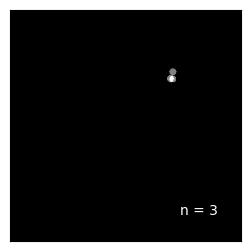

In [15]:
# Generate real-space object
N = 256
num_circles = 3
radius = 4
obj = generate_image(N, num_circles, radius)

# Plot object
fig = plot_object(obj, num_circles)

### Calculate diffraction patterns from generated images
The diffracted intensity $I(\mathbf{q})$ is well-approximated by the square modulus of the Fourier transform of the real-space object $O(\mathbf{r})$ under investigation, i.e.
$$ I(\mathbf{q}) = |F\{O(\mathbf{r})\}|^2,$$
where $F$ denotes the Fourier transform. Thus, we can quickly compute idealized diffraction patterns of our generated images using the `numpy` `fft` library.

Experimental data are also often corrupted by Poisson noise; thus, instead of using the perfect calculated diffraction intensity, we can use it to sample from a Poisson distribution in which the intensity acts as a proxy for the expected event frequency, $\lambda$.

To accomplish this in a systematic way, we will first calculate perfect diffraction patterns and normalize them by the maximum intensity value. Then, we will scale the image by the factor $\lambda_{max}$, the maximum expected event frequency, and resample each pixel from the Poisson distribution with $\lambda$ given by the pixel value. The smaller $\lambda_{max}$ is, the noisier the diffraction pattern will be.

In [16]:
def calculate_diffraction_pattern(obj, lambda_max=1e3):
    # Calculate the Fourier transform of the object
    ft = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(obj)))
    
    # Compute the square modulus of the Fourier transform and normalize by the maximum
    diff = np.abs(ft)**2
    diff /= diff.max()
    
    # Scale by the maximum expected event frequency (intensity) and corrupt with poisson noise
    return np.random.poisson(lambda_max*diff)

Play around with the object parameters `num_circles` and `radius` to see their effects on the resulting diffraction pattern. You can also vary the amount of noise added to the patterns by varying `lambda_max` (instead of the default value `1e3` = $10^3$, try other powers of 10 like `1e5`, `1e4`, `1e2`, `1e1`, etc.)

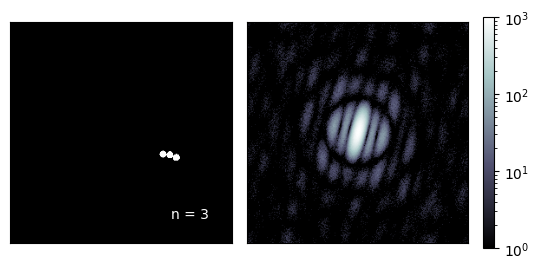

In [21]:
# Generate real-space object
N = 256
num_circles = 3
radius = 4
obj = generate_image(N, num_circles, radius)

# Calculate diffraction pattern
lambda_max = 1e3
diff = calculate_diffraction_pattern(obj, lambda_max)

# Plot object and pattern side-by-side
fig = plot_object_and_pattern(obj, diff, num_circles)

### Generate a large dataset of object image and diffraction pattern pairs
Now we want to construct a large, labeled dataset to be used for machine learning. To do this, we select a dataset size of `num_images` and fix the `radius` of all the circles, but we randomly pick the aggregate size, `num_circles`, at each iteration to be an integer on the half-open interval $[2,6)$. We then randomly generate the corresponding object and its diffraction pattern using the functions defined above. We will also save the class (or label) associated with each image as `num_circles - 2` in order to index the classes starting from 0. These labels will be what our neural network classifier will try to predict.

In [34]:
from tqdm import tqdm

# Fixed quantities
N = 256
radius = 4
min_circles = 2
max_circles = 5
num_images = 1000

# Initialize arrays for storing the datasets
objs = np.zeros((num_images, N, N))
diffs = np.zeros_like(objs)
targets = np.zeros((num_images,), dtype=int)

for i in tqdm(range(num_images), desc="Generating image data"):
    # Randomly select the number of circles to generate (an integer from 2 to 5)
    num_circles = np.random.randint(min_circles, max_circles + 1)
    targets[i] = num_circles - min_circles
    
    # Generate real-space image
    objs[i] = generate_image(N, num_circles, radius)
    
    # Calculate diffraction pattern
    diffs[i] = calculate_diffraction_pattern(objs[i], lambda_max)

Generating image data: 100%|█████████████████████████████| 1000/1000 [00:03<00:00, 256.07it/s]


Visualize a random subset of diffraction patterns from the dataset.

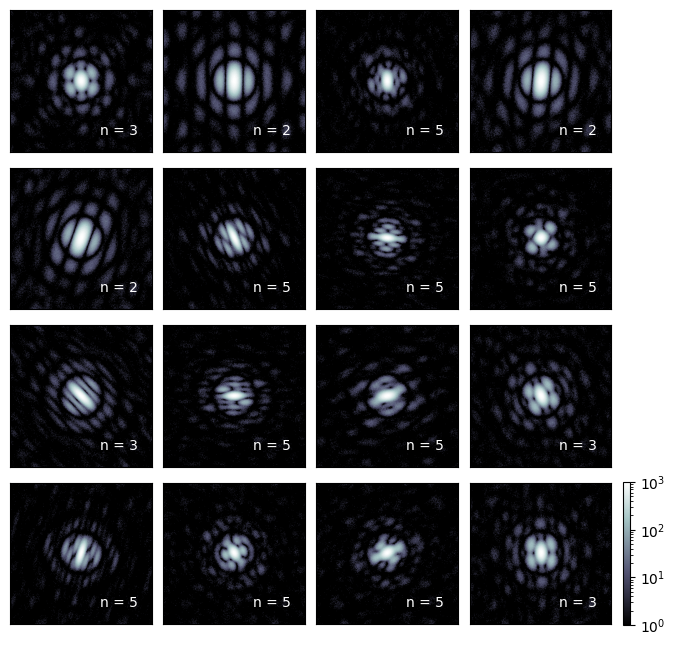

In [35]:
fig = plot_pattern_grid(diffs, targets + min_circles)

## Image classification with convolutional neural networks (CNNs)
### Build a simple CNN classifier
We will use the `PyTorch` library to build and train a neural network for classifying the diffraction patterns into one of four classes representing the four possible aggregate sizes.

In [36]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, N):
        super(SimpleCNN, self).__init__()

        # Assuming grayscale image so input channels = 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64 * (N//4) * (N//4), out_features=128)  # after two max-pooling layers
        self.fc2 = nn.Linear(in_features=128, out_features=4)  # 4 classes
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        x = self.relu(self.conv2(x))
        x = self.maxpool(x)

        x = x.view(x.size(0), -1)  # flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

### Prepare data for training
1. **Convert Numpy Arrays to PyTorch Tensors:** Use `torch.from_numpy()` to convert numpy arrays to PyTorch tensors.

2. **Normalize Data:** It's a good practice to normalize your image data to have values between [0, 1] or [-1, 1], or to have a mean of 0 and a standard deviation of 1, depending on the use case.

3. **Channel Dimension:** PyTorch expects data in the format (batch_size, channels, height, width), so we ensure the data are correctly shaped by adding an additional channel dimension for grayscale images.

4. **Dataset and DataLoader:** Create a custom dataset by subclassing `torch.utils.data.Dataset`. Then, use `DataLoader` for batching, shuffling, and parallelizing the data loading.

In [37]:
from torch.utils.data import Dataset, DataLoader

# images shape: (num_samples, height, width)
# labels shape: (num_samples, )

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        # Add channel dimension for grayscale image
        img = img[np.newaxis, :, :]

        # Convert image from numpy array to PyTorch tensor
        img = torch.from_numpy(img).float()

        if self.transform:
            img = self.transform(img)
        
        return img, label

In [38]:
# Defining the dataset using our variable names
dataset = CustomDataset(diffs, targets)

### Split the data into datasets for training and testing
Randomly split the dataset into training, validation, and test sets, and shuffle the training data at each iteration to ensure that the model doesn't see the training data in exactly the same order.

In [39]:
from torch.utils.data import DataLoader, random_split

# Define the proportion of the splits
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

# Calculate the number of samples in each split
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Use random_split to split the dataset into respective subsets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Write a training loop for the CNN
Write the training loop to optimize the SimpleCNN using the cross-entropy loss criterion. This is a common choice for classification problems, and is defined on each data point as,
$$ L_{CE} = -\sum_{i=1}^{n}t_i \log{p_i},$$
where $n$ is the total number of classes, $t_i$ gives the true class (*i.e.* is equal to 1 when $i$ is the true class and zero otherwise), and $p_i$ is the softmax probability for the $i^{th}$ class predicted by the neural network.

**Note:** `PyTorch` defines its cross-entropy loss between the target and predicted *logits* as opposed to softmax probabilities. This means that to obtain the probabilities associated with the outputs of our neural network, we need to apply the softmax function to the ouputs ourselves.

Display a progress bar and print the current accuracy on the training and validation datasets for each iteration, and save the training and validation losses and accuracies at each iteration to lists.

In [40]:
import torch
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN(N).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [41]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training loop with progress bar using tqdm
    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    train_accuracy = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.3f},",
          f"Training Accuracy: {train_accuracy*100:.2f}%, Validation Loss: {val_losses[-1]:.3f},",
          f"Validation Accuracy: {val_accuracy*100:.2f}%")

Validation Epoch 1/10: 100%|████████████████████████████████████| 7/7 [00:01<00:00,  6.38it/s]


Epoch 1/10, Training Loss: 16.639, Training Accuracy: 32.71%, Validation Loss: 1.234, Validation Accuracy: 56.50%


Validation Epoch 2/10: 100%|████████████████████████████████████| 7/7 [00:01<00:00,  6.41it/s]


Epoch 2/10, Training Loss: 1.004, Training Accuracy: 54.71%, Validation Loss: 0.727, Validation Accuracy: 68.50%


Validation Epoch 3/10: 100%|████████████████████████████████████| 7/7 [00:01<00:00,  6.53it/s]


Epoch 3/10, Training Loss: 0.692, Training Accuracy: 67.86%, Validation Loss: 0.504, Validation Accuracy: 84.50%


Validation Epoch 4/10: 100%|████████████████████████████████████| 7/7 [00:01<00:00,  6.31it/s]


Epoch 4/10, Training Loss: 0.473, Training Accuracy: 80.57%, Validation Loss: 0.328, Validation Accuracy: 91.50%


Validation Epoch 5/10: 100%|████████████████████████████████████| 7/7 [00:01<00:00,  6.45it/s]


Epoch 5/10, Training Loss: 0.355, Training Accuracy: 85.57%, Validation Loss: 0.308, Validation Accuracy: 88.50%


Validation Epoch 6/10: 100%|████████████████████████████████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch 6/10, Training Loss: 0.276, Training Accuracy: 88.86%, Validation Loss: 0.252, Validation Accuracy: 92.00%


Validation Epoch 7/10: 100%|████████████████████████████████████| 7/7 [00:01<00:00,  6.50it/s]


Epoch 7/10, Training Loss: 0.239, Training Accuracy: 91.00%, Validation Loss: 0.175, Validation Accuracy: 93.00%


Validation Epoch 8/10: 100%|████████████████████████████████████| 7/7 [00:01<00:00,  6.28it/s]


Epoch 8/10, Training Loss: 0.188, Training Accuracy: 92.14%, Validation Loss: 0.197, Validation Accuracy: 93.00%


Validation Epoch 9/10: 100%|████████████████████████████████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 9/10, Training Loss: 0.116, Training Accuracy: 96.71%, Validation Loss: 0.169, Validation Accuracy: 92.00%


Validation Epoch 10/10: 100%|███████████████████████████████████| 7/7 [00:00<00:00,  7.16it/s]

Epoch 10/10, Training Loss: 0.105, Training Accuracy: 96.29%, Validation Loss: 0.137, Validation Accuracy: 95.00%


### Evaluate the trained model

The first assessment we can make is whether the model is under- or overfit to the training data. We can start by plotting the evolution of the training and validation loss and accuracy over the course of training. A good stopping point to avoid overfitting is when the validation loss stops decreasing.

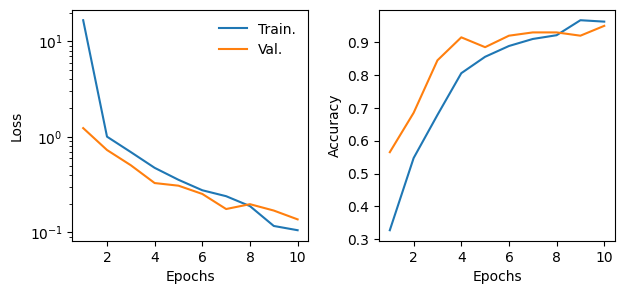

In [42]:
fig = plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

Now, let's evaluate the model on the entire test dataset and inspect both the predicted classes and associated probabilities for each data point.

In [43]:
model.eval()

# Initialize lists to store results
all_predictions = []
all_probabilities = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        
        outputs = model(inputs)
        
        # Softmax to get probabilities
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        
        # Get the probability of the predicted class
        all_probabilities.extend(probabilities[range(len(predicted)), predicted].cpu().numpy())
        
        all_true_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)
all_true_labels = np.array(all_true_labels)

Let's compare the predicted probabilities for correctly and incorrectly classified examples.

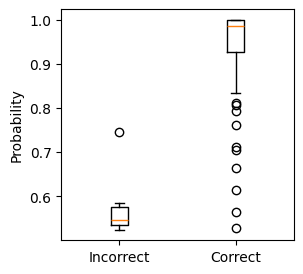

In [44]:
# Define indicators for the correctly and incorrectly classified examples
correct = all_predictions == all_true_labels
incorrect = all_predictions != all_true_labels

# Make a boxplot of predicted probabilities for correctly and incorrectly classified examples
fig = plot_classification_statistics(all_probabilities, incorrect, correct)

Another helpful assessment tool is the confusion matrix, which can be directly calculated using the `scikit-learn` library and the arrays we've constructed. Each entry $C_{i,j}$ of the confusion matrix gives the number of examples belonging to class $i$ that are classified as $j$.

In [47]:
import importlib
import sys
importlib.reload(sys.modules['plot_utils'])
from plot_utils import plot_confusion_matrix

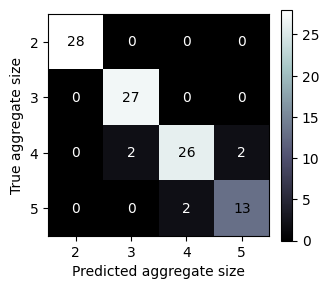

In [48]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_true_labels, all_predictions, labels=range(4))
fig = plot_confusion_matrix(cm)

Finally, we can also plot the images of the underlying objects to visualize which configurations were most difficult to classify.

In [49]:
all_objects = objs[test_dataset.indices]

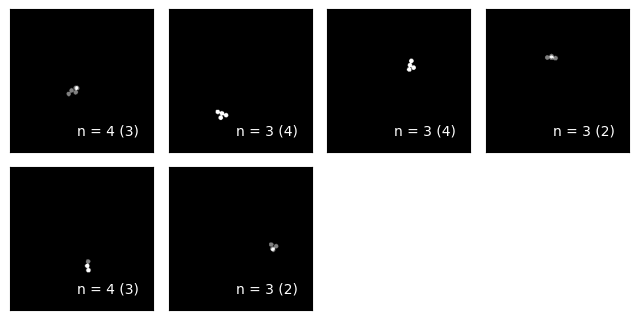

In [51]:
# Plot a grid of examples with labels denoting the true (predicted) aggregate size
labels = [str(i+1) + ' (' + str(j+1) + ')' for (i,j) in zip(all_true_labels[incorrect], all_predictions[incorrect])]
fig = plot_object_grid(all_objects[incorrect], labels)